In [1]:
# Importing libraries
import pandas as pd
import sklearn as sk
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sb


# Problem Statement

This report looks to explore product sales data of BrewDog Beer sales from csv and aims to predict sales quantities of beer sold for different product and customer combinations. 

AI can be used to significantly enhance demand forecasting and improve accuracy of forecasts through the analysis of large extensive historical data, offering the ability to consider other contrinbuting attributes of sales/product/customer data, and enabling scalability to handle growing datasets and market conditions. The automation of decision-making processes minimises errors and optimises inventory management, reducing holding costs and ensuring efficient supply chain operations.
ML models can automate the demand forecasting process, reducing the need for manual intervention. This not only saves time but also minimises error. Automated decision-making based on accurate forecasts allows organizations to optimise inventory levels and production schedules. 

This report demonstrates the process of time series forecasting using two popular ensemble learning techniques:
- XGBoost, a gradient boosting algorithm - "XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way" (xgboost developers, 2022).
- RandomForest, an ensemble of decision trees - "Random Forest is a widely-used machine learning algorithm developed by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result" (E R, 2021).

The dataset used in this analysis is a comprehensive sales history dataset. It includes detailed information about the quantities of each beer product sold over a specific time period as well categorical information on Beer types and Customer charecteristics. The dataset will be preprocessed to ensure data quality and prepared for time series forecasting using supervised learning techniques. 

We will preprocess the data, engineer features, split it into training and testing sets, and train both XGBoost and RandomForest models for predicting sales quantities.


# Load Data

In [2]:
# Load the dataset
file_path = r"C:\Users\chris.bolland\Code Projects\BDSalesHistory.csv"
salesHistory = pd.read_csv(file_path)
salesHistory_Base = salesHistory.copy()

# Pre Proccessing

## Performing steps: 
- Drop categorical fields as not useful for reggression problems
- Create new features in the dataset using averages for Daily, Weekly and Monthly values
- Drop Null values

In [3]:
#drop categorical feilds as cant be used in regression problems. The dataset includes coded values of these so they will be included 
salesHistory = salesHistory.drop(['Itemcode','Date','BaseCard','FatherCard','U_LifecycleStatus','Pack_Type','Category'], axis=1)

In [4]:
#Add additional fields with average values for Daily, Weekly and Monthly
salesHistory['daily_avg'] = salesHistory.groupby(['Item','Customer','DayOfWeek'])['QTY'].transform('mean')
salesHistory['monthly_avg'] = salesHistory.groupby(['Item','Customer','Month'])['QTY'].transform('mean')
salesHistory['weekly_avg'] = salesHistory.groupby(['Item','Customer','WeekNumber'])['QTY'].transform('mean')
salesHistory['dayofmonth_avg'] = salesHistory.groupby(['Item','Customer','DayofMonth'])['QTY'].transform('mean')

In [5]:
# Example: Drop rows with missing values
salesHistory = salesHistory.dropna()

In [6]:
salesHistory.describe()

,Item,Customer,QTY,Price,PACK_HL,Itemgroup,ABV,PLATO,Brand_Code,Item_Active,...,Month,Year,YearDay,WeekNumber,Holiday,Days to Holiday,daily_avg,monthly_avg,weekly_avg,dayofmonth_avg
count,179232.000000,179232.000000,179232.000000,1.792320e+05,179232.000000,179232.000000,179232.000000,179232.000000,179232.000000,179232.000000,...,179232.000000,179232.000000,1.792320e+05,179232.000000,179232.000000,179232.000000,179232.000000,179232.000000,179232.000000,179232.000000
mean,783.889177,1825.609724,140.572671,7.737696e+02,0.188703,161.946371,4.820605,11.280582,10579.398975,0.968521,...,6.614366,2022.112061,2.022298e+06,26.866023,0.032556,19.141827,140.572671,140.572671,140.572671,140.572671
std,520.120438,1164.972447,402.982254,3.073906e+05,0.173110,11.677891,1.668151,3.396083,1492.862098,0.174608,...,3.141531,0.767380,7.553648e+02,13.633295,0.177471,17.046036,332.230893,339.919953,361.966523,354.373654
min,253.000000,1.000000,1.000000,0.000000e+00,0.026400,159.000000,0.500000,1.800000,10000.000000,0.000000,...,1.000000,2021.000000,2.021004e+06,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,395.000000,534.000000,2.000000,1.642000e+01,0.052800,160.000000,4.500000,9.990000,10101.000000,1.000000,...,4.000000,2022.000000,2.022011e+06,16.000000,0.000000,6.000000,1.818182,1.833333,2.000000,2.000000
50%,653.000000,2259.000000,10.000000,2.283000e+01,0.079200,162.000000,5.000000,11.910000,10113.000000,1.000000,...,7.000000,2022.000000,2.022238e+06,27.000000,0.000000,14.000000,11.000000,10.125000,10.000000,10.000000
75%,727.000000,2682.000000,111.000000,8.232000e+01,0.300000,162.000000,5.400000,11.910000,10122.000000,1.000000,...,9.000000,2023.000000,2.023107e+06,38.000000,0.000000,27.000000,150.400000,148.500000,141.750000,144.000000
max,2828.000000,3634.000000,11286.000000,1.301363e+08,0.500000,319.000000,9.500000,21.350000,19586.000000,1.000000,...,12.000000,2023.000000,2.023313e+06,52.000000,1.000000,75.000000,7488.000000,7315.000000,10659.000000,7942.000000


# Split Data into Train and Test 
In order to train and accurately test the data, it is best practice to split the data into traing and testing data, as well as breaking out the target variable. 
The SKLearn train_test_split function will support creating 4 new objects as below. 

In [ ]:
#Train Test Split the dataset into 80% train vs 20% Test setting the QTY field as the target variable of the models to predict
X_train, X_test, y_train, y_test = train_test_split(salesHistory, salesHistory['QTY'], test_size=0.2, random_state=42)

# Corrolation Plot

The below heatmap shows the corrolation between different factors of the dataset. 
There are strong corrolations between Item, Plato, Name & ABV. 
We are intereseted in predictiing the QTY variable which correlates strongly against the average fields we engineered earlier which makes sense given they are dervived from QTY 
However QTY also correlats with FatherID, Year, PackHL and Item 

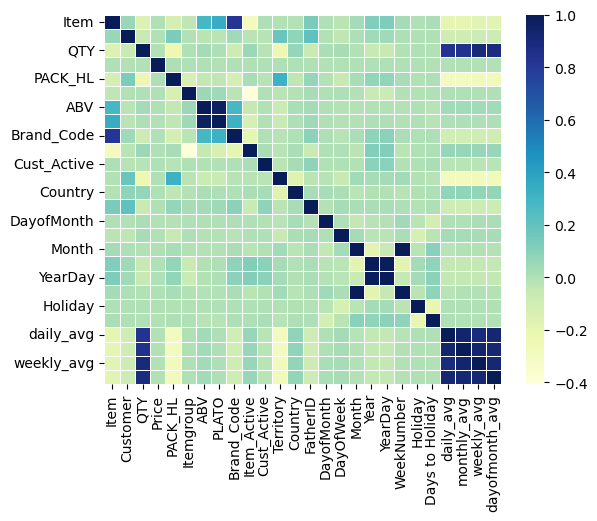

In [23]:
#Heat Map showing the corrolation between different feilds within the datasets. As shown below 
dataplot = sb.heatmap(X_train.corr(), cmap="YlGnBu",linewidths=.5) 
plt.show()

# Initialise Models

In [9]:
#Initialise the XGBoost model - Setting Estimators to 200, Max Depth to 5 and a Learning Rate of 0.1 to reduce overfitting
XGBmodel = xgb.XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=200,  
    max_depth=5,  
    learning_rate=0.1 
)

In [10]:
# Initialise the Random Forest Model - Setting Estimators to 200, depth to 5, consistent with the XGB model
RFModel = RandomForestRegressor(n_estimators = 200,   max_depth=5,  random_state = 42)

# Train Models

In [11]:
# Train the model on the training data
XGBmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [12]:
# Train the Random Forest model on training data
RFModel.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

#  Predict Values Using Test Data

In [13]:
# Make predictions on the test data using XGB Model
y_pred = XGBmodel.predict(X_test)

In [14]:
# Make predictions on the test data using Random Forest
RF_pred = RFModel.predict(X_test)

# Evaluate Model Performance

In [15]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
RF_rmse = mean_squared_error(y_test, RF_pred, squared=False)

print(f"Root Mean Squared Error XGBoost: {rmse}")
print(f"Root Mean Squared Error Random Forest: {RF_rmse}")

r2  = r2_score(y_test, y_pred)
RF_r2  = r2_score(y_test, RF_pred)

print((f"R2 Score XGBoost: {r2}"))
print((f"R2 Score Random Forest: {RF_r2}"))

Root Mean Squared Error XGBoost: 3.0868833910323032
Root Mean Squared Error Random Forest: 11.591289448806542
R2 Score XGBoost: 0.9999428524314077
R2 Score Random Forest: 0.9991942119709059


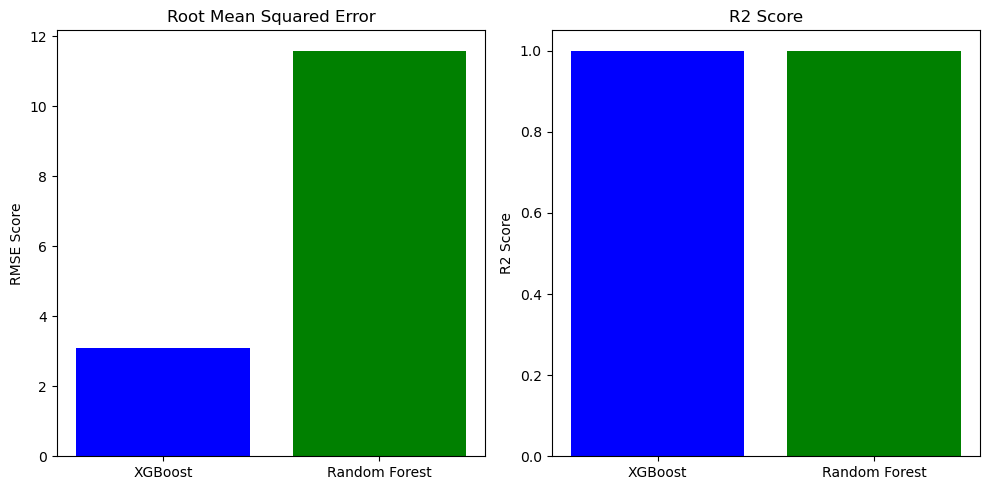

In [24]:
models = ['XGBoost', 'Random Forest']
rmse_scores = [rmse, RF_rmse]
r2_scores = [r2, RF_r2]

# Plotting RMSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_scores, color=['blue', 'green'])
plt.title('Root Mean Squared Error')
plt.ylabel('RMSE Score')

# Plotting R2 Score
plt.subplot(1, 2, 2)
plt.bar(models, r2_scores, color=['blue', 'green'])
plt.title('R2 Score')
plt.ylabel('R2 Score')

plt.tight_layout()
plt.show()

In [16]:
#Append Predictions back on to Test Dataset
X_test['XGBoost_Pred'] = y_pred
X_test['RF_Pred'] = RF_pred

# Plots and Visualisations

- Plot 1: Shows the residual values of both regression models
- Plot 2: Shows the Predicted Value vs the Actual Values for both regression models


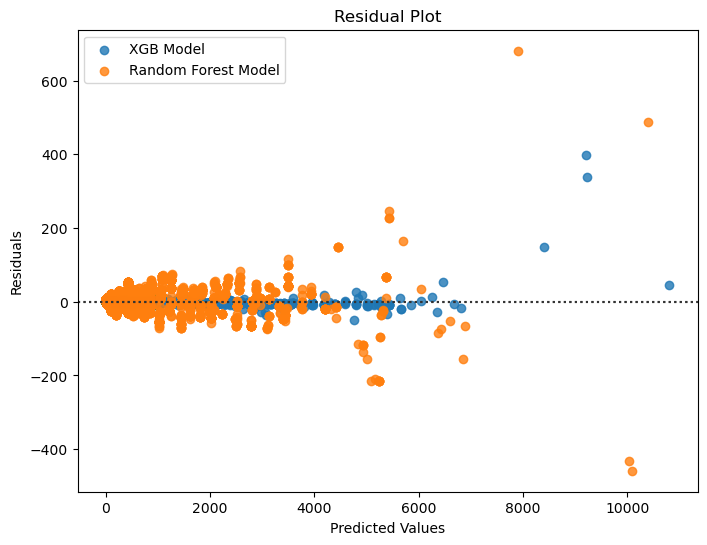

In [17]:
plt.figure(figsize=(8, 6))
sb.residplot(x=y_pred, y=y_test, label='XGB Model')
sb.residplot(x=RF_pred, y=y_test, label='Random Forest Model')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

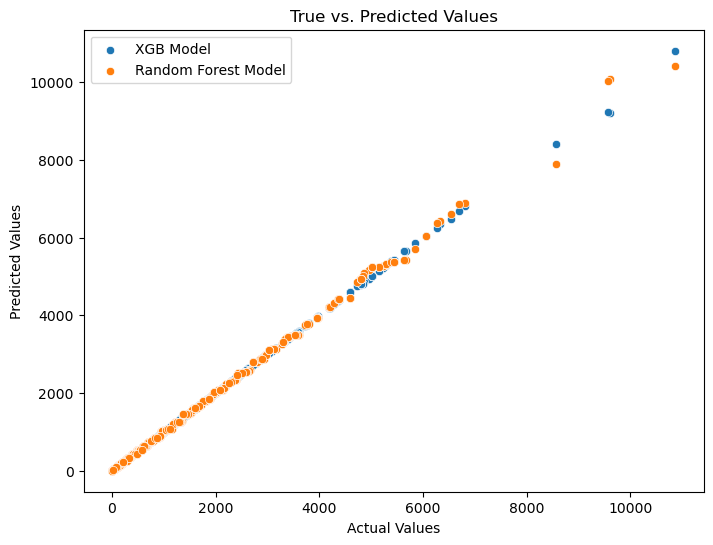

In [18]:
# Plot true vs. predicted values for better visualization
plt.figure(figsize=(8, 6))
sb.scatterplot(x=y_test, y=y_pred, label='XGB Model')
sb.scatterplot(x=y_test, y=RF_pred, label='Random Forest Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

# Extract of Single Customer - Product Combination

The below table allows us to see how both the XGBoost model and Random foreast output vs the orignal test data set for a single product and customer combination.
Observing the difference between the predicted values and the QTY feild we can see how accurately the model is calculating the QTY. 

In [26]:
X_test_197_338 = X_test.query('Customer == 197 and Item == 338')
X_test_197_338.head(25)

,Item,Customer,QTY,Price,PACK_HL,Itemgroup,ABV,PLATO,Brand_Code,Item_Active,...,YearDay,WeekNumber,Holiday,Days to Holiday,daily_avg,monthly_avg,weekly_avg,dayofmonth_avg,XGBoost_Pred,RF_Pred
148603,338,197,2508,10.70,0.0396,162,5.4,11.91,10101,1,...,2023172,25,0,16,974.368421,1221.259259,1433.142857,1332.375000,2507.915283,2523.030309
8473,338,197,836,9.94,0.0396,162,5.4,11.91,10101,1,...,2021118,17,0,3,974.368421,931.000000,940.500000,1441.000000,836.011292,851.561384
153455,338,197,1045,10.70,0.0396,162,5.4,11.91,10101,1,...,2023193,28,1,0,974.368421,766.333333,836.000000,841.500000,1044.975342,1038.265188
166712,338,197,1672,11.11,0.0396,162,5.4,11.91,10101,1,...,2023255,37,0,64,1351.000000,1149.500000,1149.500000,841.500000,1671.980713,1666.078504
137749,338,197,418,10.70,0.0396,162,5.4,11.91,10101,1,...,2023124,18,0,2,900.460000,992.750000,836.000000,1672.000000,418.030273,432.019119
16367,338,197,2090,9.94,0.0396,162,5.4,11.91,10101,1,...,2021173,25,0,14,1351.000000,1221.259259,1433.142857,965.461538,2090.002686,2083.738357
13816,338,197,1463,9.94,0.0396,162,5.4,11.91,10101,1,...,2021155,22,0,28,1135.021277,1221.259259,919.600000,1672.000000,1462.984985,1447.745356
7117,338,197,1254,9.94,0.0396,162,5.4,11.91,10101,1,...,2021106,15,0,12,1135.021277,931.000000,679.250000,1065.900000,1253.970337,1262.175289
162179,338,197,627,11.11,0.0396,162,5.4,11.91,10101,1,...,2023234,34,0,4,1351.000000,962.892857,1097.250000,965.461538,627.021362,636.881878
136786,338,197,418,10.70,0.0396,162,5.4,11.91,10101,1,...,2023117,17,0,3,900.460000,931.000000,940.500000,992.750000,417.993774,432.019119


# Conclusions 


In conclusion, the results of the analysis demonstrate that the XGBoost model outperforms the Random Forest model in terms of both R2 Score and RMSE metrics however the R2 score is extemely marginal in difference. Despite both models exhibiting a high level of accuracy on the test data, there is a suspicion of potential overfitting or the presence of factors in the data that may not accurately reflect real-world conditions. 

The exceptional accuracy observed in the models raises concerns about the generalizability of the findings to real-world situations. It is crucial to further investigate and address potential overfitting or data anomalies to ensure the models' robustness and reliability in practical applications. This underscores the importance of not solely relying on test data accuracy and emphasises the need for a comprehensive evaluation of models in real-world scenarios to validate their effectiveness.


# References 

- xgboost developers (2022). XGBoost Documentation — xgboost 1.5.1 documentation. [online] xgboost.readthedocs.io. Available at: https://xgboost.readthedocs.io/en/stable/.
- E R, S. (2021). Random Forest | Introduction to Random Forest Algorithm. [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/06/understanding-random-forest/.

